In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

### Read in the data:

In [4]:
#Load movies data
movies = pd.read_csv('ml-20m/movies.csv')
genome_scores = pd.read_csv('ml-20m/genome-scores.csv')
tags = pd.read_csv('ml-20m/tags.csv')
genome_tags = pd.read_csv('ml-20m/genome-tags.csv')
#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv('ml-20m/ratings.csv')
#ratings = ratings.drop_duplicates('movieId')

In [5]:
movies.tail()
movies['genres'] = movies['genres'].str.replace('|',' ')

In [6]:
len(movies.movieId.unique())

27278

In [7]:
len(ratings.movieId.unique())

26744

### Filtering and cleaning

In [8]:
#limit ratings to user ratings that have rated more that 55 movies -- 
#Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

In [9]:
# no worries: we have kept 97% of the original movie titles in ratings data frame
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

97.85908057775497

In [10]:
# but only 57% of the users 
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

57.797867040211415

In [11]:
#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [12]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [14]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [ ]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)


### Merge the movies and the tags data frame and create a metadata tag for each movie:

In [13]:
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched,1.417737e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation,1.183903e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature,1.183933e+09


In [14]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...


### Creating a content latent matrix from movie metadata:
#### tf-idf vectors and truncated SVD :

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(26694, 23704)


#### The first 200 components explain over 50% of the variance:

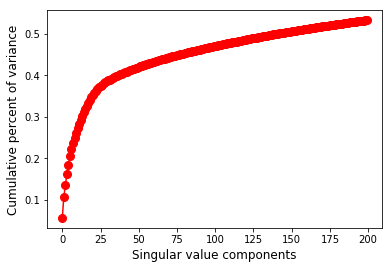

In [16]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [17]:
#number of latent dimensions to keep
n = 200 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [18]:
# our content latent matrix:
latent_matrix.shape

(26694, 200)

### Creating a collaborative latent matrix from user ratings:

In [19]:
ratings_f.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [20]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [21]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [22]:
ratings_f2.head(3)

userId,1,2,3,5,7,8,11,13,14,16,...,138474,138475,138477,138483,138484,138486,138487,138490,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,...,5.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,3.5
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,4.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


In [23]:
len(ratings_f.movieId.unique())

26694

In [24]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

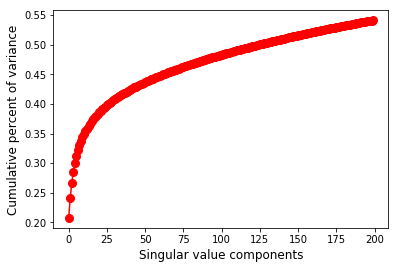

In [25]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

### Running a content / collaborative and hybrid cosine Similarity: 

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Strada, La (1954)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Strada, La (1954)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Burnt by the Sun (Utomlyonnye solntsem) (1994),0.783687,0.347234,0.565460
Babette's Feast (Babettes gæstebud) (1987),0.745094,0.610579,0.677836
Purple Noon (Plein soleil) (1960),0.730353,0.528732,0.629543
Mon Oncle (My Uncle) (1958),0.662756,0.946326,0.804541
Sundays and Cybele (Les dimanches de Ville d'Avray) (1962),0.640997,0.592128,0.616563
Kolya (Kolja) (1996),0.621453,0.326573,0.474013
"Nights of Cabiria (Notti di Cabiria, Le) (1957)",0.612939,0.834067,0.723503
Moscow Does Not Believe in Tears (Moskva slezam ne verit) (1979),0.611397,0.695872,0.653635
Journey of Hope (Reise der Hoffnung) (1990),0.608204,0.597546,0.602875
Hamlet (1948),0.592787,0.496560,0.544674


### Use matrix factorization model:

In [1]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [13]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.7728


0.7727642384605172

In [15]:
def pred_user_rating(ui):
    if ui in ratings_f.userId.unique():
        ui_list = ratings_f[ratings_f.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [18]:
user_id = 7020
pred_user_rating(user_id)


,ratings
movies,
Bleak House (2005),4.850939
Prime Suspect (1991),4.795222
Bill Hicks: Revelations (1993),4.789093
"Children of Heaven, The (Bacheha-Ye Aseman) (1997)",4.723910
Heimat - A Chronicle of Germany (Heimat - Eine deutsche Chronik) (1984),4.718742
Song of the Little Road (Pather Panchali) (1955),4.693297
Betrayal (1983),4.684712
"Wings of Desire (Himmel über Berlin, Der) (1987)",4.683682
Witness for the Prosecution (1957),4.674544
